In [28]:
import pandas as pd

columns = ["unit", "time", "op1", "op2", "op3", "sensor1", "sensor2", "sensor3",
           "sensor4", "sensor5", "sensor6", "sensor7", "sensor8", "sensor9",
           "sensor10", "sensor11", "sensor12", "sensor13", "sensor14",
           "sensor15", "sensor16", "sensor17", "sensor18", "sensor19",
           "sensor20", "sensor21", "_1", "_2", "_3"]

files = ["CMAPSSData/train_FD001.txt", "CMAPSSData/train_FD002.txt",
         "CMAPSSData/train_FD003.txt", "CMAPSSData/train_FD004.txt"]

df_list = []

for i, file in enumerate(files, start=1):
    df_temp = pd.read_csv(file, sep=" ", header=None, names=columns, engine="python")
    df_temp["unit"] = df_temp["unit"] + (i * 1000)
    df_list.append(df_temp)

df_2 = pd.concat(df_list, ignore_index=True)
df_2 = df_2.drop(columns=["_1", "_2", "_3"])

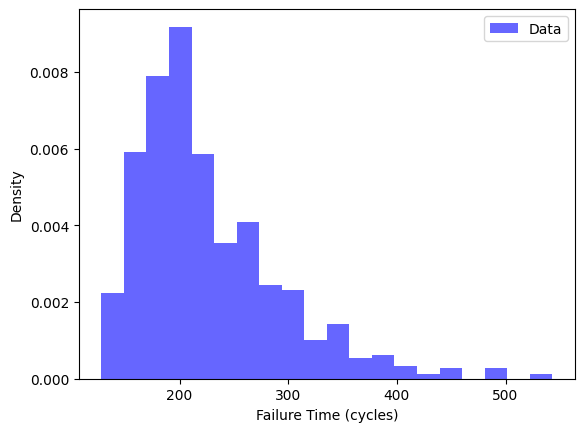

In [29]:
# time is an engine's operational cycle count, the max value is the failure time - last recorded cycle
failure_times = df_2.groupby("unit")["time"].max()

plt.hist(failure_times, bins=20, density=True, alpha=0.6, color='b', label="Data")
plt.xlabel("Failure Time (cycles)")
plt.ylabel("Density")
plt.legend()
plt.show()

# failure times are the last recorded cycle for each engine


(array([0.00169932, 0.00118953, 0.00543783, 0.00594763, 0.00611756,
        0.00696722, 0.00849661, 0.00968614, 0.01036586, 0.00713715,
        0.00594763, 0.00577769, 0.00492803, 0.00390844, 0.00288885,
        0.0042483 , 0.00441824, 0.00271892, 0.00305878, 0.00186925,
        0.00288885, 0.00220912, 0.00084966, 0.00186925, 0.0005098 ,
        0.00152939, 0.00169932, 0.0005098 , 0.00067973, 0.0005098 ,
        0.00101959, 0.0005098 , 0.00033986, 0.00033986, 0.00016993,
        0.00016993, 0.00016993, 0.        , 0.00033986, 0.00033986,
        0.        , 0.        , 0.00016993, 0.00033986, 0.00016993,
        0.        , 0.        , 0.00016993, 0.        , 0.00016993]),
 array([128. , 136.3, 144.6, 152.9, 161.2, 169.5, 177.8, 186.1, 194.4,
        202.7, 211. , 219.3, 227.6, 235.9, 244.2, 252.5, 260.8, 269.1,
        277.4, 285.7, 294. , 302.3, 310.6, 318.9, 327.2, 335.5, 343.8,
        352.1, 360.4, 368.7, 377. , 385.3, 393.6, 401.9, 410.2, 418.5,
        426.8, 435.1, 443.4, 451.7

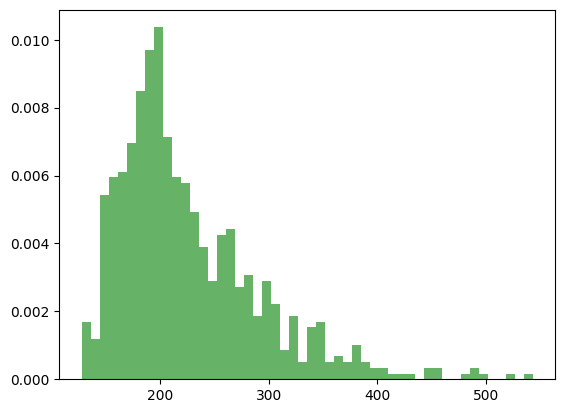

In [30]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

plt.hist(failure_times, bins=50, density=True, alpha=0.6, color='g', label='Data')


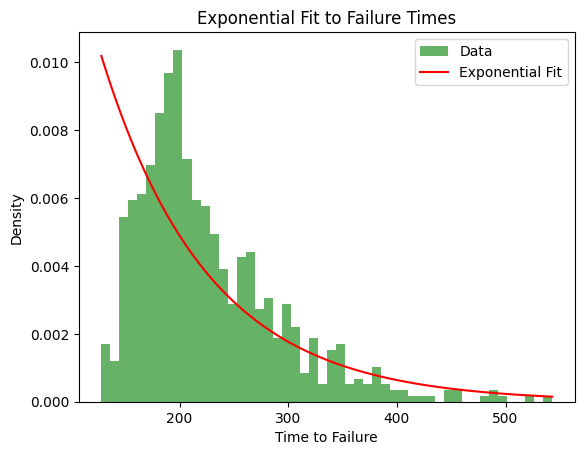

In [38]:
# exponential distribution assumes constant failure over time and is good for systems with memoryless failure behavior 

loc, scale = stats.expon.fit(failure_times)
x = np.linspace(min(failure_times), max(failure_times), 1000)
pdf_fitted = stats.expon.pdf(x, loc=loc, scale=scale)

plt.hist(failure_times, bins=50, density=True, alpha=0.6, color='g', label='Data')
plt.plot(x, pdf_fitted, 'r-', label='Exponential Fit')
plt.legend()
plt.title('Exponential Fit to Failure Times')
plt.xlabel('Time to Failure')
plt.ylabel('Density')
plt.show()


Exponential distribution assumes that of an engine has been running for 100 cycles is just as likely to fail in the next cycle as the one that has been running for 5, because of the memoryless property.  Past time does  affect future failure risk in this data set, engines start off healthy, and over time, sensor readings drift as parts degrade some engines fail early due to initial manufacturing variability, most fail in certain points in time as shown.

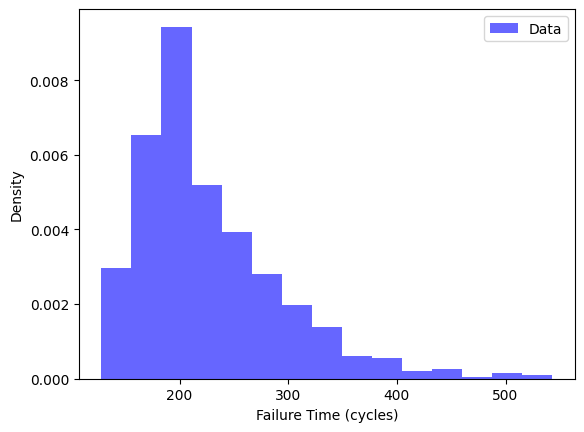

In [42]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

#data displayed in less bins

plt.hist(failure_times, bins=15, density=True, alpha=0.6, color='b', label="Data")
plt.xlabel("Failure Time (cycles)")
plt.ylabel("Density")
plt.legend()
plt.show()


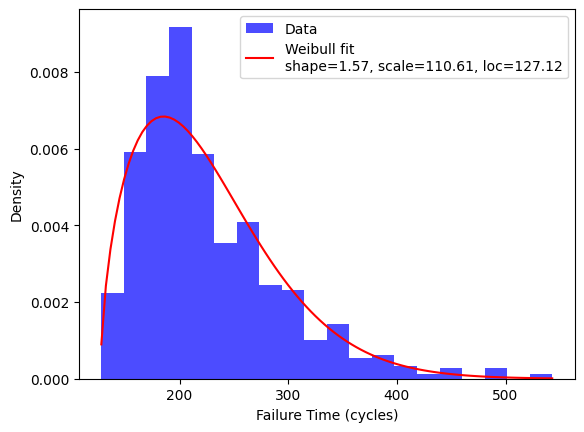

In [56]:
shape, loc, scale = stats.weibull_min.fit(failure_times)

x = np.linspace(failure_times.min(), failure_times.max(), 100)
y = stats.weibull_min.pdf(x, shape, loc, scale)

plt.hist(failure_times, bins=20, density=True, alpha=0.7, color='b', label="Data")
plt.plot(x, y, 'r-', label=f'Weibull fit\nshape={shape:.2f}, scale={scale:.2f}, loc={loc:.2f}')
plt.xlabel("Failure Time (cycles)")
plt.ylabel("Density")
plt.legend()
plt.show()

# Weibull distribution assumes failure rate is either constant, increasing, or decreasing
# healthy engines may fail far later than the Weibull distribution predicts, especially if it is caused by
# latent factors and degradation processes that are not captured by the model
# it does capture the basic curve where early failures occur due to defects, and late failures happen because 
# of wear-out, but in this dataset they do not follow a simple Weibull tail



In [57]:
# kolmogorov-smirnov test compares data and distribution to see if they are the same
# null hypothesis: data follows Weibull distribution
# alternative hypothesis: data does not follow said distribution

from scipy.stats import kstest

# K-S test for eibull distribution
D, p_value = kstest(failure_times, 'weibull_min', args=(shape, loc, scale))

print(f"K-S test result: D={D:.4f}, p-value={p_value:.4f}")


K-S test result: D=0.0574, p-value=0.0180


Since the p-value is 0.018 (<0.05) we reject the null hypothesis, and this is statistical evidence that the failure times do not follow a Weibull distribution.

The Anderson-Darling test is a statistical test used to assess whether a given sample of data comes from a specified probability distribution. It might perfom better due to its sensitivity to deviations from the theoretical distribution, especially in the tails, where our data differs most from Weibull distribution.

In [58]:
from scipy.stats import anderson
result = anderson(failure_times, dist='weibull_min')

print(f"statistic: {result.statistic:.4f}")
print(f"critical values: {result.critical_values}")
print(f"significance level: {result.significance_level}")

statistic: 3.0676
critical values: [0.342 0.472 0.563 0.636 0.758 0.88  1.043 1.168]
significance level: [0.5   0.75  0.85  0.9   0.95  0.975 0.99  0.995]


Since the test statistic is greater than all of the critical values, we reject the null hypothesis.

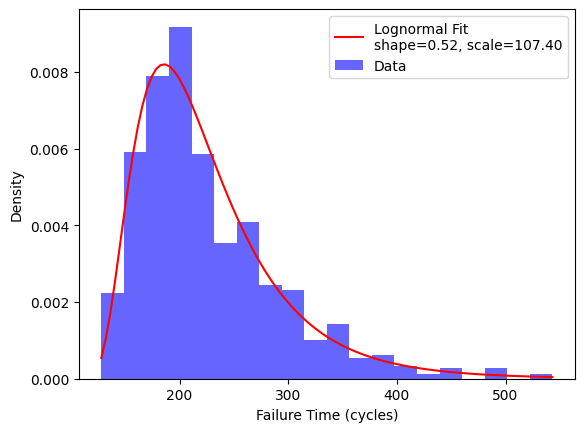

In [59]:
x = np.linspace(failure_times.min(), failure_times.max(), 100)
shape, loc, scale = stats.lognorm.fit(failure_times)
y = stats.lognorm.pdf(x, shape, loc, scale)


plt.plot(x, y, 'r-', label=f'Lognormal Fit\nshape={shape:.2f}, scale={scale:.2f}')
plt.hist(failure_times, bins=20, density=True, alpha=0.6, color='b', label="Data")
plt.xlabel("Failure Time (cycles)")
plt.ylabel("Density")
plt.legend()
plt.show()

A log-normal distribution might fit this scenario because it is often used to model data where the result often depends on multiple factors, and some may be unknown. 

In [62]:
D, p_value = kstest(failure_times, 'lognorm', args=(shape, loc, scale))

print(f"K-S test result: D={D:.4f}, p-value={p_value:.4f}")

K-S test result: D=0.0332, p-value=0.4070


The K-S test result for log normal distribution indicates weak evidence against the null hypothesis. This means that there is no significant evidence to suggest that the data does not follow a log-normal distribution.



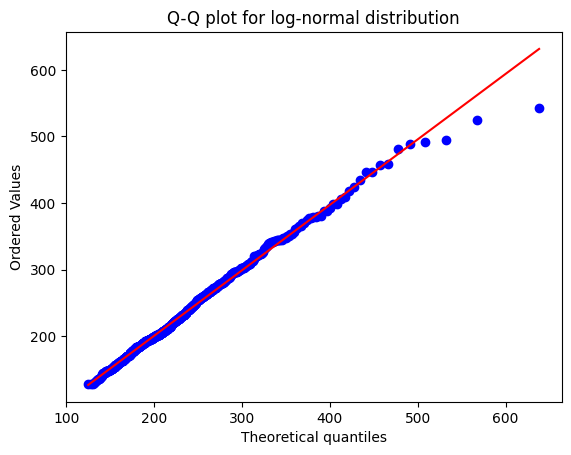

In [65]:
stats.probplot(failure_times, dist="lognorm", sparams=(shape, loc, scale), plot=plt)
plt.title("Q-Q plot for log-normal distribution")
plt.show()



The Q-Q plot compares the quantiles (sorted data values) of the dataset to the quantiles of a theoretical distribution. If they match, the data follows that distribution. The difference shown in this plot indicate slight mismatches in tail, where the largest failure times lie. This means the model slightly overestimates the failure times of engines that fail later. 